In [27]:
from pyrosm import OSM
import geopandas as gpd
import pandas as pd
import networkx as nx
import osmnx as ox
from shapely.geometry import Point, Polygon, MultiPoint
import folium
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from matplotlib.lines import Line2D
import alphashape
import contextily 
from descartes import PolygonPatch
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from faker import Faker


ModuleNotFoundError: No module named 'faker'

<Axes: >

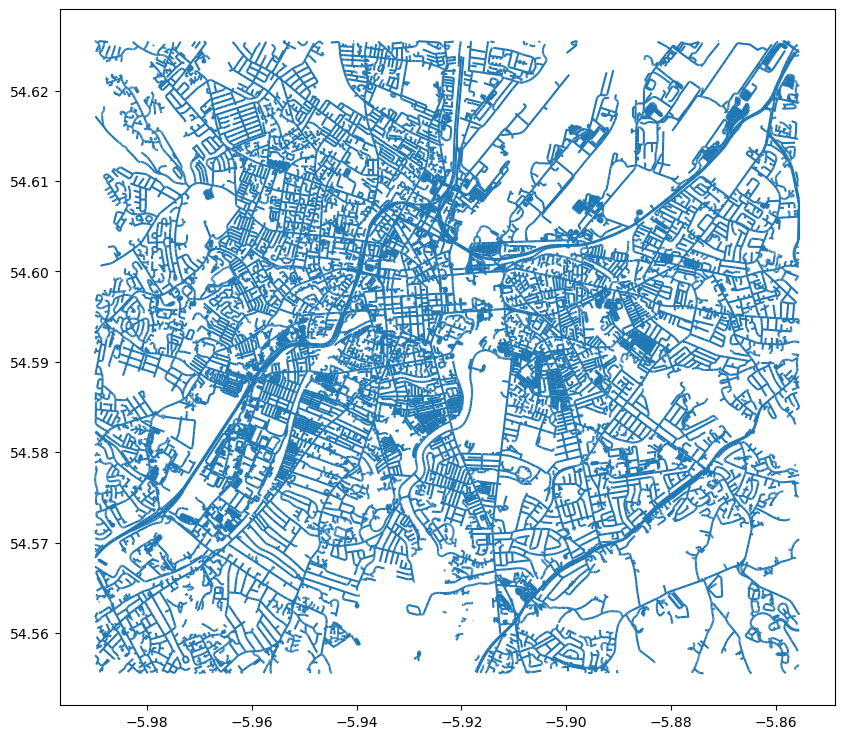

In [3]:
# assign file path to osm pbf file.
base_road_path = 'C:/Users/hular/projects/ClosestDestination/testEnvironment/Data/belfast_slightly_trimmed.osm.pbf'

osm = OSM(base_road_path)

#load road network from graph
G_network = osm.get_network(network_type = 'driving', nodes = True)

# #Convert to ga graph (this will create if not a pyrosm source)
# if not isinstance(G, nx.Graph):
#     G = nx.from_pandas_edgelist(G, source='u', target='v', edge_attr=True)

nodes, edges = osm.get_network(network_type='driving', nodes=True)

#generate graph of network
G = osm.to_graph(nodes, edges, graph_type='networkx')

edges.plot(figsize=(10,10))


In [4]:
#load in the data which service areas will be analysed.
#sticking it in a try loop forces it to work.
service_locations_csv = pd.read_csv('C:/Users/hular/projects/ClosestDestination/testEnvironment/Data/libraries_belfast_2024_very_trimmed.csv')

def csv_to_gdf(csv:str, x_col:str, y_col:str, input_crs:int, crs_conversion:int = None):
    """ function to convert csv to a gdf based off X, Y coordinates and input CRS. Optional CRS conversion.
        Parameters:
    - csv: DataFrame, source data.
    - x: str, column name for the x coordinate.
    - y: str, column name for the y coordinate.
    - input_crs: int, EPSG code for input coordinate reference system.
    - crs_conversion: int, optional EPSG code for converting CRS."""
    #create a list for each row of geom by zipping and turn into a point tuple
    try:
        csv['geometry'] = list(zip(csv[x_col], csv[y_col]))
        csv['geometry'] = csv['geometry'].apply(Point)
        # Convert to GeoDataFrame
        gdf = gpd.GeoDataFrame(csv, geometry='geometry', crs=f'EPSG:{input_crs}')
        #Only converts if specified
        if crs_conversion:
            gdf = gdf.to_crs(epsg=crs_conversion)
        return gdf
    except Exception:
        print(f'Exception error: {Exception}')
        
        
service_locations = csv_to_gdf(csv=service_locations_csv, x_col= 'X COORDINATE', y_col= 'Y COORDINATE', input_crs = 29902, crs_conversion=4326)



In [25]:

#Function to create a dict of names and nearest names to be called in a loop creating the subgraphs for each location.
def nearest_node_and_name(graph, start_locations:gpd.GeoDataFrame,  location_name:str = None, anon_name:bool = False):
    """ Creates a dictionary of location names and nearest node on Graph. If no location name column specified, creates a list.
    
        Parameters:
        graph (networkx.Graph): The graph representing the network, often as `G` in networkx.
        start_locations (GeoDataFrame): Geopandas GeoDataFrame of start locations.
        location_name (str): Column storing name of start location.
        """   
    service_xy = None
    location_name = location_name
    start_locations
    if location_name is None and anon_name == False:
        service_xy = []
    else:
        service_xy = {}
    
    if anon_name == True:
        fake=Fake
        fake_names = [fake_names() for i in range(len(start_locations))]
        start_locations['name'] =fake_names
            
    
    for index, row in start_locations.iterrows():
        #extract x and y for each library
        location_x = row['geometry'].x
        location_y = row['geometry'].y
        #calculate the nearest node on the Graph
        nearest_node = ox.distance.nearest_nodes(graph, location_x, location_y)
        # extract the library name into a dict or a list
        if location_name:
            name = row[location_name]
            service_xy[name] = {'nearest_node': nearest_node}
        else:
            service_xy.append(nearest_node)
    return start_locations[''] 

service_locations_nearest_node = nearest_node_and_name(G, service_locations, location_name='Static Library Name')


In [26]:
print(service_locations_nearest_node)

{'Ballyhackamore Library': {'nearest_node': 73250694}, 'Finaghy Library': {'nearest_node': 8417220926}, 'Grove Library': {'nearest_node': 3732169380}, 'Woodstock Library': {'nearest_node': 11186018716}}


In [5]:
#Function to iterate through star locations. Input must be from a dict/array e.g. Ardoyne Library: POLYGON((-5.49, 54.6),(-5.55, 54.4))
#Next step to iterate over cutoff list. e.g. [1000, 2000,3000,4000]

def single_source_polygon(nearest_node_dict:dict, graph, search_distances:list, alpha_value:int, weight:str):
    """
    Generates a GeoDataFramecontaining polygons of service areas calculated using Dijkstra's algorithm within a networkx graph. 
    Each polygon represents a service area contour defined by a maximum distance from a source node.

    Parameters:
        nearest_node_dict (dict): A dictionary with names as keys and the nearest node on the graph as values. This is an output from the `nearest_node_and_name` function.
        graph (networkx.Graph): The graph representing the network, often designated as `G` in networkx.
        cutoffs (list of int): Distances in meters that define the bounds of each service area.
        alpha_value (int): The alpha value used to create non-convex polygons via the alphashape method.
        weight (str): The edge attribute in the graph to use as a weight.

    Returns:
        GeoDataFrame: A GeoPandas DataFrame containing the service area polygons for each node specified in `nearest_node_dict`.

    """
    
    # service_areas_dict = {} #uncomment with services_ares_dict[name]
    data_for_gdf = []

    #For each start location [name] creates a polygon around the point.
    for name in nearest_node_dict:
        #cycle through each distance in list supplied
        for distance in search_distances:
            #Extract nearest node to the name (start location)
            nearest_node = nearest_node_dict[name]['nearest_node']
            subgraph = nx.single_source_dijkstra_path_length(graph, nearest_node, cutoff=distance, weight = weight)
            
            #Creates a list of all nodes which are reachable within the cutoff.
            reachable_nodes = list(subgraph.keys())
            node_points_list = []
            for node in reachable_nodes:
                x = graph.nodes[node]['x']
                y = graph.nodes[node]['y']
                node_points_list.append(Point(x, y))

            # Makes the x,y values into just a list of tuples to be used with alpha shape
            node_points_series = pd.Series(node_points_list)
            node_point_series_tuples_list = node_points_series.apply(lambda point: (point.x, point.y))
            correct_points_list = node_point_series_tuples_list.tolist()
            
            #Create an alpha shape for each polygon.
            alpha_shape = alphashape.alphashape(correct_points_list, alpha_value)
        
            data_for_gdf.append({'name': name, 'distance':distance, 'geometry': alpha_shape})
            # service_areas_dict[name] = alpha_shape #uncomment to check if function returns correct variables

    gdf_alpha = gpd.GeoDataFrame(data_for_gdf, crs= 4326)
    
        
    #return the geodataframe
    return gdf_alpha
search_distances = [1000,2000,3000]
alpha_areas = single_source_polygon(nearest_node_dict= service_locations_nearest_node, graph = G, 
                                    search_distances=search_distances, alpha_value=500, weight='length')

# Uncomment pprint to check output is correct.
# import pprint
# pprint.pprint(alpha_areas) 

Network areas have successfully been dissolved and differenced


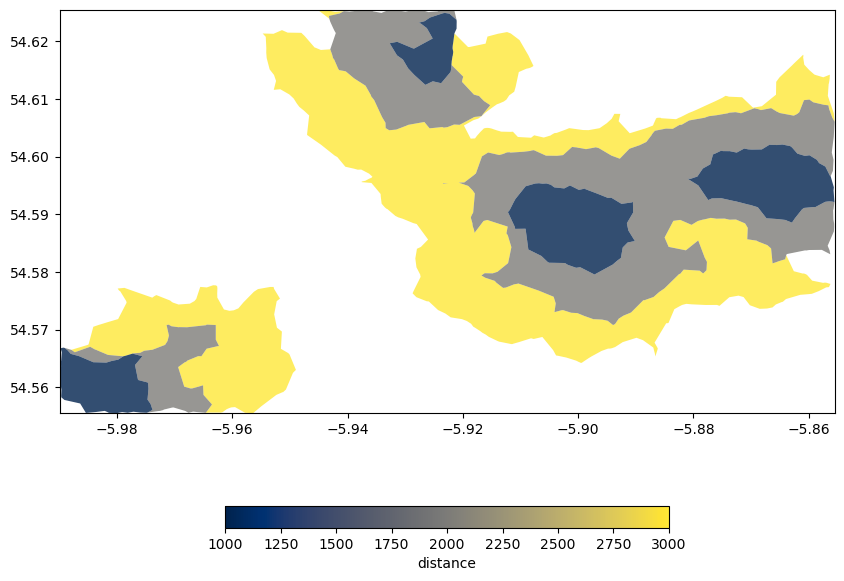

A map showing contours has been created.
                                            geometry  distance
0  MULTIPOLYGON (((-5.95172 54.57537, -5.95228 54...      3000
1  MULTIPOLYGON (((-5.98864 54.56670, -5.98816 54...      2000
2  MULTIPOLYGON (((-5.97466 54.56082, -5.97460 54...      1000


In [6]:
#Need to make function include the smallest geom which doesn't difference.
def network_area_bands(geodataframe:gpd.GeoDataFrame, dissolve_cat, aggfunc:str ='first', show_graph:bool=False):
    """ 
    Dissolves polygons in a GeoDataFrame by category type. Currently only supports dissolve categories which are buffer area integers.
    Differencing occurs based upon <Larger size - next smaller size>.
    Parameters:
        geodataframe (gpd.GeoDataFrame): Geopandas Data Frame.
        dissolve_cat (int): Column to dissolve dataframe by. Must be an integer as the polygons will difference based on ordered size.
        aggfunc (func or str): Aggregation function, same as the geopandas.GeoSeries.dissole argument. {Default: 'first'}
        show_graph (bool): Shows a simple graph of network area bands using matplotlib. {Default: None}
        """
        #Smallest first, e.g. 1000, then 2000, then 3000
    data_for_gdf = []
    differenced_geoms = []
    category_values = []
    #Subset dataframe by dissolve category then run dissolve, dissolving and then subsetting creates invalid geoms.
    search_distances = geodataframe[dissolve_cat].unique()
    for distance in search_distances:
        filtered_data = geodataframe[geodataframe[dissolve_cat] == distance].reset_index(drop=True)
        filtered_data_dissolved = filtered_data.dissolve(aggfunc=aggfunc)
        data_for_gdf.append(filtered_data_dissolved)
    #Create gdf for each dissolved category
    gdf_dissolve = gpd.GeoDataFrame(pd.concat(data_for_gdf, ignore_index=True), crs='EPSG:4326')
    
    #sort data so that the smallest area which cannot be differenced is exluded.
    #iterates so that the larger area which is a lower indexis differenced by the geom above it.
    gdf_dissolve_sorted = gdf_dissolve.sort_values(by=dissolve_cat, ascending=False)
    for index in range(0,len(gdf_dissolve_sorted)-1):
        differenced_part = gdf_dissolve_sorted.geometry.iloc[index].difference(gdf_dissolve_sorted.geometry.iloc[index+1])
        differenced_geoms.append(differenced_part)
        category_values.append(gdf_dissolve_sorted.iloc[index][dissolve_cat])

    #append the smallest geom as this is excluded from the dissolve difference loop.
    final_index = (len(gdf_dissolve_sorted)-1)
    differenced_geoms.append(gdf_dissolve_sorted.iloc[final_index]['geometry'])
    category_values.append(gdf_dissolve_sorted.iloc[final_index][dissolve_cat])
    #append geometry to geodataframe to return as final result
    differenced_gdf = gpd.GeoDataFrame({'geometry': differenced_geoms, dissolve_cat: category_values})
    print('Network areas have successfully been dissolved and differenced')
    #produces a quick and ready map for instant analysis.
    if show_graph:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        differenced_gdf.plot(column=dissolve_cat, cmap='cividis', alpha=0.8, ax=ax, legend=True,
                                legend_kwds={'label': dissolve_cat, 'orientation': 'horizontal',
                                            'fraction': 0.036})
        plt.autoscale(enable=True, axis='both', tight=True)
        plt.show()
        print('A map showing contours has been created.')
    
    return differenced_gdf

dissolved_alpha_areas = network_area_bands(alpha_areas, dissolve_cat='distance',aggfunc='first', show_graph=True)
print(dissolved_alpha_areas)